# Figures for squidpy.im methods (mibitof data)

Contains:
- calculation of features from images and comparison with data contained in adata
- see also tutorial_mibitof in squidpy docs

In [70]:
import scanpy as sc
import squidpy as sq

import numpy as np

import matplotlib.pyplot as plt

adata = sq.datasets.mibitof()

In [71]:
imgs = []
for library_id in adata.uns["spatial"].keys():
    img = sq.im.ImageContainer(adata.uns["spatial"][library_id]["images"]["hires"], library_id=library_id)
    img.add_img(adata.uns["spatial"][library_id]["images"]["segmentation"], library_id=library_id, layer="segmentation")
    img["segmentation"].attrs["segmentation"] = True
    imgs.append(img)
img = sq.im.ImageContainer.concat(imgs)

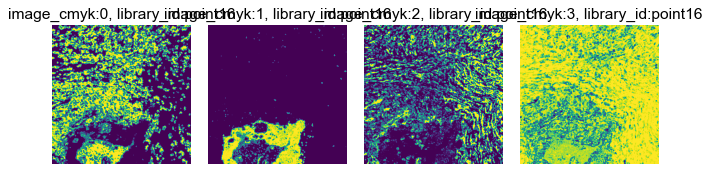

In [73]:
def rgb2cmyk(arr):
    """Convert arr from RGB to CMYK color space."""
    R = arr[..., 0] / 255
    G = arr[..., 1] / 255
    B = arr[..., 2] / 255
    K = 1 - (np.max(arr, axis=-1) / 255)
    C = (1 - R - K) / (1 - K + np.finfo(float).eps)  # avoid division by 0
    M = (1 - G - K) / (1 - K + np.finfo(float).eps)
    Y = (1 - B - K) / (1 - K + np.finfo(float).eps)
    return np.stack([C, M, Y, K], axis=3)


img.apply(rgb2cmyk, layer="image", new_layer="image_cmyk", copy=False)
img.show("image_cmyk", channelwise=True, library_id='point16')

In [76]:
def segmentation_image_intensity(arr, image_cmyk):
    """
    Calculate per-channel mean intensity of the center segment.

    arr: the segmentation
    image_cmyk: the raw image values
    """
    import skimage.measure

    # the center of the segmentation mask contains the current label
    # use that to calculate the mask
    s = arr.shape[0]
    mask = (arr == arr[s // 2, s // 2, 0, 0]).astype(int)
    # use skimage.measure.regionprops to get the intensity per channel
    features = []
    for c in range(image_cmyk.shape[-1]):
        feature = skimage.measure.regionprops_table(
            np.squeeze(mask),  # skimage needs 3d or 2d images, so squeeze excess dims
            intensity_image=np.squeeze(image_cmyk[:, :, :, c]),
            properties=["mean_intensity"],
        )["mean_intensity"][0]
        features.append(feature)
    return features

# remove nan spatial coords
adata = adata[~np.isnan(adata.obsm['spatial'][:,0])]


# calc mean intensity
sq.im.calculate_image_features(
    adata,
    img,
    library_id="library_id",
    features="custom",
    spot_scale=10,
    layer="segmentation",
    features_kwargs={"custom": {"func": segmentation_image_intensity, "additional_layers": ["image_cmyk"]}},
)

  0%|          | 0/3309 [00:00<?, ?/s]

In [77]:
# transform mean intensities as in original paper
adata.obsm["img_features_transformed"] = np.arcsinh(adata.obsm["img_features"] / 0.05)

## Create plots

In [ ]:
sc.settings.dpi = 300

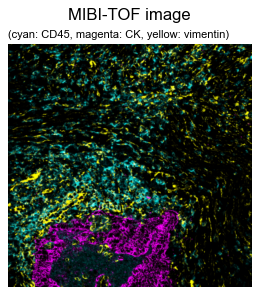

In [55]:
fig, ax = plt.subplots(1,1)
ax.imshow(adata.uns['spatial']['point16']['images']['hires'])
ax.axis('off')
ax.set_title('MIBI-TOF image\n', fontdict={'fontsize':15})
plt.text(x=0.38, y=0.93, s= "(cyan: CD45, magenta: CK, yellow: vimentin)", fontsize=10, ha="left", transform=fig.transFigure)
plt.savefig('figures/mibitof/mibitof.png', dpi=300, bbox_inches='tight')

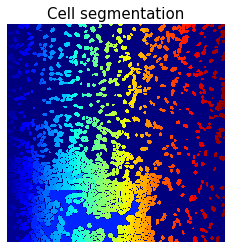

In [46]:
fig, ax = plt.subplots(1,1)
ax.imshow(adata.uns['spatial']['point16']['images']['segmentation'], cmap='jet', interpolation='none')
ax.axis('off')
ax.set_title('Cell segmentation', fontdict={'fontsize':15})
plt.savefig('figures/mibitof/mibitof_segmented.png', dpi=300, bbox_inches='tight')

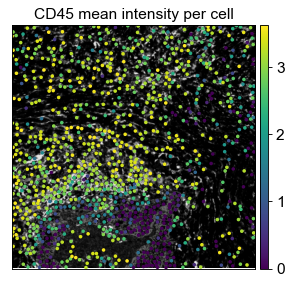

In [63]:
# save mean intensity of anti-neun channel
sc.set_figure_params(facecolor="white", figsize=(8, 4))
fig, ax = plt.subplots(figsize=(8, 4))
sc.pl.spatial(
    sq.pl.extract(adata, 'img_features_transformed'), 
    library_id='point16',
    color=['segmentation_image_intensity_0'],
    bw=True, 
    crop_coord=(0,1024,0,1024),
    title='',
    show=False,
    ax=ax,
    vmax='p99',
    vmin='p01'
)
ax.set_title('CD45 mean intensity per cell', loc='center')
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)

plt.savefig('figures/mibitof/mibitof_cd45.png', dpi=300, bbox_inches='tight')

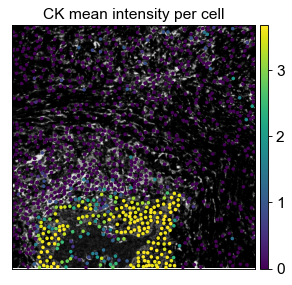

In [62]:
# save mean intensity of anti-neun channel
sc.set_figure_params(facecolor="white", figsize=(8, 4))
fig, ax = plt.subplots(figsize=(8, 4))
sc.pl.spatial(
    sq.pl.extract(adata, 'img_features_transformed'), 
    library_id='point16',
    color=['segmentation_image_intensity_1'],
    bw=True, 
    crop_coord=(0,1024,0,1024),
    title='',
    show=False,
    ax=ax,
    vmax='p99',
    vmin='p01'
)
ax.set_title('CK mean intensity per cell', loc='center')
ax.axes.xaxis.label.set_visible(False)
ax.axes.yaxis.label.set_visible(False)

plt.savefig('figures/mibitof/mibitof_ck.png', dpi=300, bbox_inches='tight')

### for supplementary

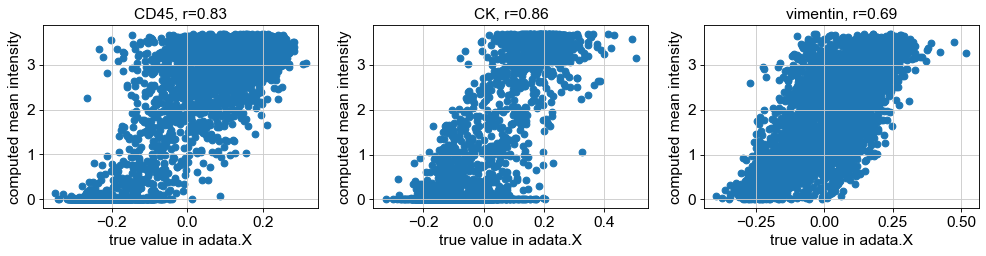

In [79]:
# plot scatterplots
channels = ["CD45", "CK", "vimentin"]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axes):
    X = np.array(adata[:, channels[i]].X.todense())[:, 0]
    Y = adata.obsm["img_features_transformed"][f"segmentation_image_intensity_{i}"]
    ax.scatter(X, Y)
    ax.set_xlabel("true value in adata.X")
    ax.set_ylabel("computed mean intensity")
    corr = np.corrcoef(X, Y)[1, 0]
    ax.set_title(f"{channels[i]}, r={corr:.2f}")
plt.savefig('figures/mibitof/mibitof_scatterplot.png', dpi=300, bbox_inches='tight')